# Cross-validation framework


## Learning Objectives

By the end of this notebook, you will understand:
- Why we need to split data into training and testing sets
- The difference between training error and testing error
- What overfitting means and why it's problematic
- How cross-validation provides more robust model evaluation
- How to interpret cross-validation results and their variability

## What is Cross-Validation?

Cross-validation is a fundamental technique in machine learning that helps us:
1. **Evaluate model performance more reliably** than a single train-test split
2. **Detect overfitting** by comparing training and testing errors
3. **Estimate how well our model will generalize** to new, unseen data
4. **Choose between different models** or hyperparameters

Think of it as getting multiple "second opinions" about your model's performance rather than relying on just one test.

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

## Dataset Introduction

We'll use the California Housing dataset to demonstrate cross-validation concepts. This dataset is ideal for learning because:
- It's a **regression problem** (predicting continuous house prices)
- It has real-world complexity with multiple features
- It's large enough to show meaningful cross-validation results
- The target variable (house prices) is something we can intuitively understand

Let's load the data and explore its basic structure:

In this dataset, the aim is to predict the median value of houses in an area
in California. The features collected are based on general real-estate and
geographical information.

Therefore, the task to solve is different from the one shown in the previous
notebook. The target to be predicted is a continuous variable and not anymore
discrete. This task is called regression.

Thus, we will use a predictive model specific to regression and not to
classification.

In [2]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [3]:
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


To simplify future visualization, let's transform the prices from the 100
(k\\$) range to the thousand dollars (k\\$) range.

In [4]:
target *= 100
target

0        452.6
1        358.5
2        352.1
3        341.3
4        342.2
         ...  
20635     78.1
20636     77.1
20637     92.3
20638     84.7
20639     89.4
Name: MedHouseVal, Length: 20640, dtype: float64

## The Central Problem in Machine Learning

Before we dive into cross-validation, let's understand the fundamental challenge we're trying to solve:

**The Goal**: Build a model that performs well on *new, unseen data* (not just the data we trained on)

**The Challenge**: We only have a limited dataset to work with

**The Risk**: Our model might just memorize the training data instead of learning generalizable patterns

This is where the concepts of **training error** vs **testing error** become crucial. Let's see this in action:

## Training error vs testing error

To solve this regression task, we will use a decision tree regressor.

In [5]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


After training the regressor, we would like to know its potential
generalization performance once deployed in production. For this purpose, we
use the mean absolute error, which gives us an error in the native unit, i.e.
k\\$.

In [6]:
from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 0.00 k$


### Red Flag Alert! 

**Question for you**: Does this result seem realistic? Should we celebrate this "perfect" performance?

**The Answer**: No! This is actually a warning sign. Here's why:

1. **Real-world data is noisy** - Perfect predictions are extremely rare
2. **Our model likely memorized** rather than learned patterns
3. **This won't generalize** to new houses

This is a classic example of **overfitting**. Let's investigate further...

We get perfect prediction with no error. It is too optimistic and almost
always revealing a methodological problem when doing machine learning.

Indeed, we trained and predicted on the same dataset. Since our decision tree
was fully grown, every sample in the dataset is stored in a leaf node.
Therefore, our decision tree fully memorized the dataset given during `fit`
and therefore made no error when predicting.

This error computed above is called the **empirical error** or **training
error**.


We trained a predictive model to minimize the training error but our aim is to
minimize the error on data that has not been seen during training.

This error is also called the **generalization error** or the "true" **testing
error**.


Thus, the most basic evaluation involves:

* splitting our dataset into two subsets: a training set and a testing set;
* fitting the model on the training set;
* estimating the training error on the training set;
* estimating the testing error on the testing set.

So let's split our dataset.

## The Solution: Train-Test Split

To get a realistic assessment of our model's performance, we need to:

1. **Hide some data** from the model during training (test set)
2. **Train only on the remaining data** (training set) 
3. **Evaluate on the hidden data** to simulate real-world performance

### Key Principles:
- **Never** let your model see the test data during training
- The test set represents "future" data your model hasn't seen
- This gives us an honest estimate of generalization performance

### Typical Split Ratios:
- **75% training, 25% testing** (what we'll use)
- Sometimes 80/20 or 70/30 depending on dataset size

Let's implement this approach:

In [7]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0
)

Then, let's train our model.

In [8]:
regressor.fit(data_train, target_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


Finally, we estimate the different types of errors. Let's start by computing
the training error.

In [9]:
target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"The training error of our model is {score:.2f} k$")

The training error of our model is 0.00 k$


We observe the same phenomena as in the previous experiment: our model
memorized the training set. However, we now compute the testing error.

In [10]:
target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"The testing error of our model is {score:.2f} k$")

The testing error of our model is 47.31 k$


This testing error is actually about what we would expect from our model if it
was used in a production environment.

### But Wait... Is One Split Enough?

We got a testing error of ~45k$, but **how confident should we be in this number?**

Consider these concerns:
1. **What if we got "lucky" with our split?** Maybe the test set happened to contain easy-to-predict houses
2. **What if we got "unlucky"?** Maybe the test set contained unusually difficult cases
3. **Would a different random split give similar results?**

**The Answer**: We need multiple splits to get a more reliable estimate. This is where **cross-validation** comes in!

## Stability of the cross-validation estimates

When doing a single train-test split we don't give any indication regarding
the robustness of the evaluation of our predictive model: in particular, if
the test set is small, this estimate of the testing error will be unstable and
wouldn't reflect the "true error rate" we would have observed with the same
model on an unlimited amount of test data.

For instance, we could have been lucky when we did our random split of our
limited dataset and isolated some of the easiest cases to predict in the
testing set just by chance: the estimation of the testing error would be
overly optimistic, in this case.

**Cross-validation** allows estimating the robustness of a predictive model by
repeating the splitting procedure. It will give several training and testing
errors and thus some **estimate of the variability of the model generalization
performance**.

There are [different cross-validation
strategies](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators),
for now we are going to focus on one called "shuffle-split". At each iteration
of this strategy we:

- randomly shuffle the order of the samples of a copy of the full dataset;
- split the shuffled dataset into a train and a test set;
- train a new model on the train set;
- evaluate the testing error on the test set.

We repeat this procedure `n_splits` times. Keep in mind that the computational
cost increases with `n_splits`.



In this case we will set `n_splits=40`, meaning that we will train 40 models
in total and all of them will be discarded: we just record their
generalization performance on each variant of the test set.

To evaluate the generalization performance of our regressor, we can use
[`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
with a
[`sklearn.model_selection.ShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)
object:

### Understanding the Cross-Validation Process

Imagine we repeat our train-test split process multiple times:

```
Split 1: [Train: 70%] [Test: 30%] → Model 1 → Test Error 1
Split 2: [Train: 70%] [Test: 30%] → Model 2 → Test Error 2  
Split 3: [Train: 70%] [Test: 30%] → Model 3 → Test Error 3
...
Split 40: [Train: 70%] [Test: 30%] → Model 40 → Test Error 40
```

**What we get**:
- 40 different test error estimates
- A **distribution** of performance rather than a single number
- **Mean**: Our best estimate of model performance  
- **Standard deviation**: How much the performance varies

**Why this is better**:
- More robust estimate (not dependent on one "lucky" or "unlucky" split)
- Confidence intervals around our performance estimate
- Better understanding of model stability

In [11]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error"
)

The results `cv_results` are stored into a Python dictionary. We will convert
it into a pandas dataframe to ease visualization and manipulation.

In [12]:
import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,0.127236,0.001780,-46.840980
1,0.114392,0.001771,-46.941809
2,0.112983,0.001790,-47.251479
3,0.115022,0.001900,-44.183649
4,0.111573,0.001648,-47.494374
5,0.114250,0.001657,-45.945164
6,0.114687,0.001768,-47.040937
7,0.116322,0.002119,-45.914011
8,0.134275,0.001864,-45.576302
9,0.114714,0.001742,-45.690516


<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Tip</p>
<p>A score is a metric for which higher values mean better results. On the
contrary, an error is a metric for which lower values mean better results.
The parameter <tt class="docutils literal">scoring</tt> in <tt class="docutils literal">cross_validate</tt> always expect a function that is
a score.</p>
<p class="last">To make it easy, all error metrics in scikit-learn, like
<tt class="docutils literal">mean_absolute_error</tt>, can be transformed into a score to be used in
<tt class="docutils literal">cross_validate</tt>. To do so, you need to pass a string of the error metric
with an additional <tt class="docutils literal">neg_</tt> string at the front to the parameter <tt class="docutils literal">scoring</tt>;
for instance <tt class="docutils literal"><span class="pre">scoring="neg_mean_absolute_error"</span></tt>. In this case, the negative
of the mean absolute error will be computed which would be equivalent to a
score.</p>
</div>

Let us revert the negation to get the actual error:

In [13]:
cv_results["test_error"] = -cv_results["test_score"]

Let's check the results reported by the cross-validation.

In [14]:
cv_results.head(10)

,fit_time,score_time,test_score,test_error
0,0.127236,0.001780,-46.840980,46.840980
1,0.114392,0.001771,-46.941809,46.941809
2,0.112983,0.001790,-47.251479,47.251479
3,0.115022,0.001900,-44.183649,44.183649
4,0.111573,0.001648,-47.494374,47.494374
5,0.114250,0.001657,-45.945164,45.945164
6,0.114687,0.001768,-47.040937,47.040937
7,0.116322,0.002119,-45.914011,45.914011
8,0.134275,0.001864,-45.576302,45.576302
9,0.114714,0.001742,-45.690516,45.690516


We get timing information to fit and predict at each cross-validation
iteration. Also, we get the test score, which corresponds to the testing error
on each of the splits.

In [15]:
len(cv_results)

40

We get 40 entries in our resulting dataframe because we performed 40 splits.
Therefore, we can show the testing error distribution and thus, have an
estimate of its variability.

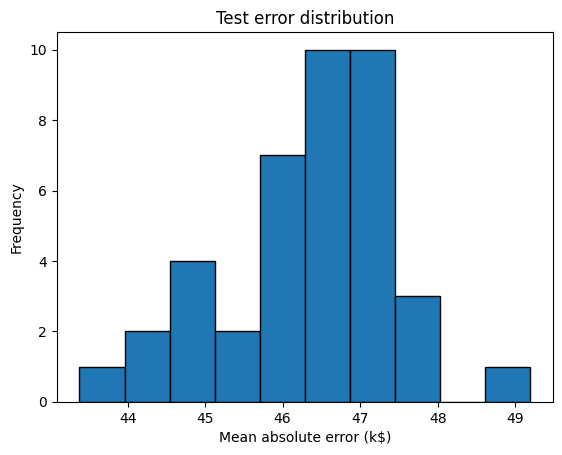

In [16]:
import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")

We observe that the testing error is clustered around 47 k\\$ and ranges from
43 k\\$ to 50 k\\$.

In [17]:
print(
    "The mean cross-validated testing error is: "
    f"{cv_results['test_error'].mean():.2f} k$"
)

The mean cross-validated testing error is: 46.35 k$


In [18]:
print(
    "The standard deviation of the testing error is: "
    f"{cv_results['test_error'].std():.2f} k$"
)

The standard deviation of the testing error is: 1.14 k$


### How to Interpret These Results

**Our cross-validation results: 46.36 ± 1.14 k$**

**What this means**:
- **46.36 k$**: Our best estimate of the model's typical error
- **± 1.14 k$**: The uncertainty in this estimate (95% of results fall within ~2 standard deviations)
- **Range**: We expect most test errors to fall between ~44-48 k$

**Why the small standard deviation is good**:
- It means our model's performance is **consistent** across different data splits
- We can be **confident** in our performance estimate
- The model is **stable** (not highly dependent on which specific data it sees)

**Key Question**: Is this performance good enough for our use case?

Note that the standard deviation is much smaller than the mean: we could
summarize that our cross-validation estimate of the testing error is 46.36 ±
1.17 k\\$.

If we were to train a single model on the full dataset (without
cross-validation) and then later had access to an unlimited amount of test
data, we would expect its true testing error to fall close to that region.

While this information is interesting in itself, it should be contrasted to
the scale of the natural variability of the vector `target` in our dataset.

Let us plot the distribution of the target variable:

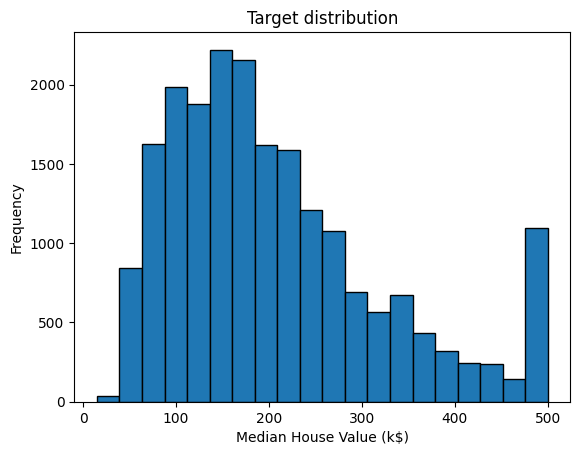

In [19]:
target.plot.hist(bins=20, edgecolor="black")
plt.xlabel("Median House Value (k$)")
_ = plt.title("Target distribution")

In [20]:
print(f"The standard deviation of the target is: {target.std():.2f} k$")

The standard deviation of the target is: 115.40 k$


The target variable ranges from close to 0 k\\$ up to 500 k\\$ and, with a
standard deviation around 115 k\\$.

We notice that the mean estimate of the testing error obtained by
cross-validation is a bit smaller than the natural scale of variation of the
target variable. Furthermore, the standard deviation of the cross validation
estimate of the testing error is even smaller.

This is a good start, but not necessarily enough to decide whether the
generalization performance is good enough to make our prediction useful in
practice.

We recall that our model makes, on average, an error around 47 k\\$. With this
information and looking at the target distribution, such an error might be
acceptable when predicting houses with a 500 k\\$. However, it would be an
issue with a house with a value of 50 k\\$. Thus, this indicates that our
metric (Mean Absolute Error) is not ideal.

We might instead choose a metric relative to the target value to predict: the
mean absolute percentage error would have been a much better choice.

But in all cases, an error of 47 k\\$ might be too large to automatically use
our model to tag house values without expert supervision.

## More detail regarding `cross_validate`

During cross-validation, many models are trained and evaluated. Indeed, the
number of elements in each array of the output of `cross_validate` is a result
from one of these `fit`/`score` procedures. To make it explicit, it is
possible to retrieve these fitted models for each of the splits/folds by
passing the option `return_estimator=True` in `cross_validate`.

In [21]:
cv_results = cross_validate(regressor, data, target, return_estimator=True)
cv_results

{'fit_time': array([0.1513958 , 0.13328004, 0.14644194, 0.13651609, 0.13063598]),
 'score_time': array([0.00130105, 0.00113297, 0.00145292, 0.00112104, 0.0013299 ]),
 'estimator': [DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0)],
 'test_score': array([0.27732469, 0.33848299, 0.39778592, 0.19071784, 0.41346361])}

In [22]:
cv_results["estimator"]

[DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0)]

The five decision tree regressors corresponds to the five fitted decision
trees on the different folds. Having access to these regressors is handy
because it allows to inspect the internal fitted parameters of these
regressors.

In the case where you only are interested in the test score, scikit-learn
provide a `cross_val_score` function. It is identical to calling the
`cross_validate` function and to select the `test_score` only (as we
extensively did in the previous notebooks).

In [23]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, target)
scores

array([0.27732469, 0.33848299, 0.39778592, 0.19071784, 0.41346361])

## Quick Check: Test Your Understanding

Before we wrap up, see if you can answer these questions:

1. **Why was our first model's "perfect" performance suspicious?**
2. **What's the difference between training error and testing error?**
3. **Why is cross-validation better than a single train-test split?**
4. **What does the standard deviation in our cross-validation results tell us?**
5. **How would you decide if our 46k$ error is "good enough"?**

Think about your answers, then continue to the summary below!

## Summary

### Key Takeaways

**1. The Overfitting Problem**
- Models can memorize training data instead of learning patterns
- Perfect training performance is usually a red flag
- Always evaluate on unseen data

**2. Train-Test Split Fundamentals**  
- Essential for honest performance evaluation
- Training error ≠ testing error (and testing error is what matters)
- Never let your model see test data during training

**3. Cross-Validation Benefits**
- More robust than single train-test split
- Provides performance distribution, not just single number
- Helps detect unstable models
- Better confidence in model selection

**4. Practical Insights**
- Our model: 46.36 ± 1.17 k$ error (quite stable!)
- Context matters: compare error to target scale (~115 k$ std)
- Consider business impact: Is 47k$ error acceptable for your use case?

### Next Steps
- Try different cross-validation strategies (K-fold, stratified, etc.)
- Compare multiple models using cross-validation
- Explore hyperparameter tuning with nested cross-validation
- Learn about bias-variance tradeoff